In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.ensemble import AdaBoostClassifier

from torch.utils.tensorboard import SummaryWriter

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

2024-07-22 19:32:55.367367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 19:32:55.367453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 19:32:55.368088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 19:32:55.372499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target='5pct_10day_TARGET')
y_orig = targetdf["Target"]
print(y_orig.shape)
#targetdf.rename(columns={"DayAfterMajorReversal":'Target'}, inplace=True)
targetdf.head()

(2371,)


Target
date            
1/13/2015   HOLD
1/14/2015    BUY
1/15/2015    BUY
1/16/2015    BUY
1/20/2015    BUY

In [4]:
# make sure we split train and test data with shuffle OFF
X_train, X_test, y_train, y_test = train_test_split(stockdf,y_orig, train_size=0.8,shuffle=False)
# other_test will be used later to help evaluate the efficacy of our predictions, by calculating a return on investment
other_test = otherdf.iloc[-y_test.shape[0]:]

#my stockutils does not remove the index, so...
#y_test.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True, inplace=True)


#Problem is for cross validation splits, this won't work, so...

# use a TimeSeriesSplit to do cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

In [5]:
y_test.shape

(475,)

In [6]:
wandb.login(key="d2e07e8a9d7ef675859816d6e8230c50ccd2846d")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: candrews1971 (christopherandrews). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Base ROI

In [7]:
import math
bah_actuals = pd.DataFrame(data=y_test, columns=["Target"], index=y_test.index.copy())
bah_actuals['close'] = other_test['close']
max_ROI = stockutils.calculate_total_gains_bhs(bah_actuals, init_value=1000, init_price=bah_actuals['close'][0])

num_bought = math.floor(1000/ bah_actuals['close'][0])
bah_ROI = (bah_actuals['close'][-1] - bah_actuals['close'][0])

Buying 6 shares for 151.60. Remaining Balance: 90.40000000000009
Selling all shares for 173.19, cash balance: $1129.54
Buying 8 shares for 140.09. Remaining Balance: 8.819999999999936
Selling all shares for 147.27, cash balance: $1186.98
Buying 8 shares for 138.88. Remaining Balance: 75.94000000000005
Selling all shares for 150.18, cash balance: $1277.38
Buying 10 shares for 126.04. Remaining Balance: 16.980000000000018
Selling all shares for 153.20, cash balance: $1548.98
Buying 10 shares for 145.31. Remaining Balance: 95.88000000000011
Selling all shares for 191.94, cash balance: $2015.2800000000002
Buying 11 shares for 176.57. Remaining Balance: 73.01000000000022
Selling all shares for 184.12, cash balance: $2098.3300000000004
Buying 12 shares for 170.43. Remaining Balance: 53.1700000000003
Selling all shares for 180.71, cash balance: $2221.6900000000005
Buying 12 shares for 171.10. Remaining Balance: 168.4900000000007
Buying 1 shares for 166.89. Remaining Balance: 1.600000000000704

# Decision Tree Classifier

In [8]:
#wandb.init(entity="christopherandrews", project="StockPredictor", name="DecisionTreeClassifier_v01", save_code=False)

In [9]:
y_test.head()

date
7/26/2022    BUY
7/27/2022    BUY
7/28/2022    BUY
7/29/2022    BUY
8/1/2022     BUY
Name: Target, dtype: category
Categories (3, object): ['BUY', 'HOLD', 'SELL']

In [10]:

# Create the DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=2, random_state=2)

#set up for a Grid Search 
dtc_param_grid = {'max_depth':[1,2,3,4,5,6,7], 
                  'min_samples_split': [2,4,8,16,32,64], 
                  'min_samples_leaf': [2,4,8,16,32,64]}

#log to weights and biases
run_name = f"DecisionTreeClassifier_5_10_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True)

#Perform the training with a grid search
dtc_gs = GridSearchCV(dt, param_grid=dtc_param_grid, cv=tscv, scoring='accuracy', verbose=True)
dtc_gs.fit(X_train, y_train)

y_pred = dtc_gs.predict(X_test) #uses best estimator

#log accuracy score
run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
dtc_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
dtc_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(dtc_preds, init_value=1000, init_price=dtc_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])

run.finish()

Fitting 10 folds for each of 252 candidates, totalling 2520 fits
Accuracy:  0.6610526315789473
Selling all remaining held shares, cash balance: $1000.0 ***********************


In [11]:
#In case the above fails
#run.finish()

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

<Axes: >

Hold seems to be a problem...

In [13]:
logged_config = dtc_gs.best_params_
logged_config["Model"] = "DecisionTreeClassifier"

56% accuracy, hmmm...  that's hardly better than just a guess!

In [14]:
# Get the best paramters from the model
dtc_gs.best_params_

{'max_depth': 1,
 'min_samples_leaf': 64,
 'min_samples_split': 2,
 'Model': 'DecisionTreeClassifier'}

In [15]:
outputfilepath = os.path.join(IMAGES_PATH, "GridSearchDTC.dot")
export_graphviz(dtc_gs.best_estimator_, out_file=outputfilepath, feature_names=X_train.columns, class_names=["BUY","HOLD",'SELL'], rounded=True, filled=True )

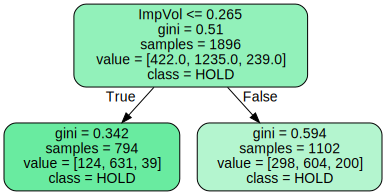

In [16]:
Source.from_file(outputfilepath)

<Axes: >

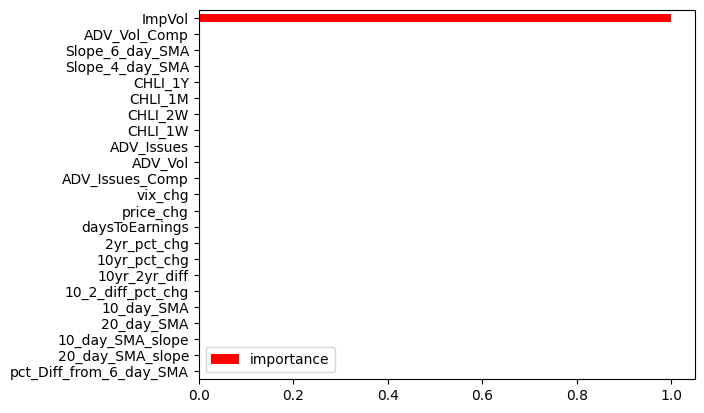

In [17]:
feature_importances = list(zip(X_train.columns, dtc_gs.best_estimator_.feature_importances_))
fi = pd.Series(dtc_gs.best_estimator_.feature_importances_, index=X_train.columns)
sorted_imp = pd.DataFrame(fi.sort_values(ascending=True), columns=['importance'])
sorted_imp.plot(kind='barh',color="red")

It only seems to want to use the 6 and 10 day SMA slope...

# AdaBoost Classifier


In [18]:
adb_param_grid = {"learning_rate":[0.001, 0.01, 0.1],
                  'n_estimators':[50, 100, 200] }

#log to weights and biases
run_name = f"AdaBoostClassifier_5_10_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True)

adb_clf = AdaBoostClassifier(estimator=dt, algorithm='SAMME', n_estimators=200, random_state=42)

adb_gs = GridSearchCV(adb_clf, param_grid=adb_param_grid, cv=tscv, scoring='accuracy', verbose=True)

adb_gs.fit(X_train, y_train)

y_pred = adb_gs.predict(X_test) #uses best estimator

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))


# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
adb_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
adb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(adb_preds, init_value=1000, init_price=adb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])

run.finish()

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Accuracy:  0.6463157894736842
Buying 5 shares for 191.94. Remaining Balance: 40.299999999999955
Selling all remaining held shares, cash balance: $1111.5 ***********************


In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

<Axes: >

In [20]:
feature_importances = list(zip(X_train.columns, adb_gs.best_estimator_.feature_importances_))
fi = pd.Series(adb_gs.best_estimator_.feature_importances_, index=X_train.columns)
sorted_imp = pd.DataFrame(fi.sort_values(ascending=True), columns=['importance'])
sorted_imp.plot(kind='barh',color="red")

<Axes: >

We end up using a few more features, and get a fairly surprising 64% accuracy.

# Gradient Boosting Classifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

# adb_param_grid = {"learning_rate":[0.001, 0.01, 0.1],
#                   'n_estimators':[50, 100, 200] }

#log to weights and biases
run_name = f"GradientBoostClassifier_5_10_{int(time.time())}"
run = wandb.init(entity="christopherandrews", project="StockPredictor", name=run_name, save_code=False, settings=wandb.Settings(start_method="fork"), reinit=True)


#Use a time series split as the CV
tscv = TimeSeriesSplit(n_splits=8)

gbc = GradientBoostingClassifier(max_depth=2, random_state=42, loss='log_loss')

gbc_params = {'learning_rate':[0.001], 'n_estimators':[ 800]}

#RandomizedSearchCV
gbc_gs = GridSearchCV(gbc, param_grid=gbc_params, cv=tscv, scoring='accuracy', verbose=True)

gbc_gs.fit(X_train, y_train)


y_pred = gbc_gs.predict(X_test) #uses best estimator
#y_probas = gbc_gs.predict_proba(X_test)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
#run.summary['precision'] = precision_score(y_test, y_pred)
#run.summary['recall'] = recall_score(y_test, y_pred)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
gbc_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
gbc_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(gbc_preds, init_value=1000, init_price=gbc_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Accuracy: ", accuracy_score(y_test, y_pred))
#wandb.sklearn.plot_roc(y_test, y_probas, ["BUY", "HOLD", "SELL"])
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])
#wandb.sklearn.plot_learning_curve(gbc_gs.best_estimator_, X_train, y_train)
run.finish()

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Buying 7 shares for 142.41. Remaining Balance: 3.1299999999999955
Selling all shares for 195.10, cash balance: $1368.83
Buying 7 shares for 193.89. Remaining Balance: 11.599999999999909
Selling all shares for 188.04, cash balance: $1327.8799999999999
Selling all remaining held shares, cash balance: $1327.8799999999999 ***********************
Accuracy:  0.6421052631578947


This is quite slow compared to XGBoost

In [22]:
run.finish()

In [23]:
gbc_gs.best_params_

{'learning_rate': 0.001, 'n_estimators': 800}

<Axes: >

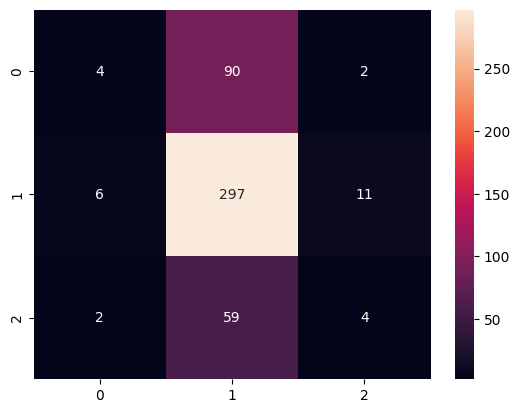

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

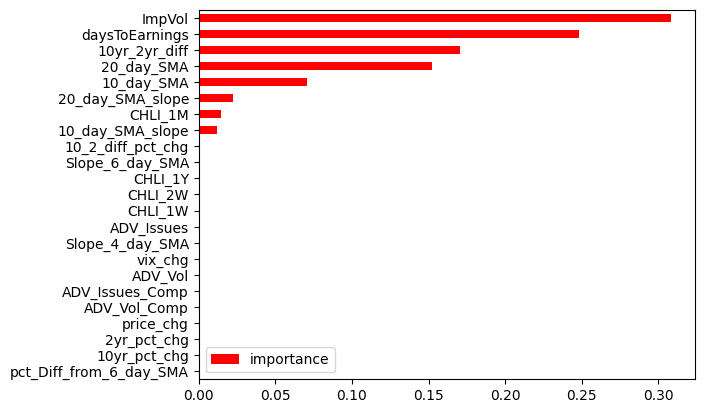

In [25]:
stockutils.plot_feature_importances(X_train=X_train, estimator=gbc_gs.best_estimator_)



BUT, it always predicts a buy or sell, never hold!  

# Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:

#log to weights and biases
run_name = f"RandomForestClassifier_5_10_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

#tscv = TimeSeriesSplit(n_splits=8)
tscv = 10

#cls = StackingClassifier(max_depth=2, random_state=42, loss='log_loss')
cls = RandomForestClassifier(random_state=42)

#Base classifier 
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

print("Base classifier accuracy:", accuracy_score(y_test, y_pred))


#gbc_params = {'learning_rate':[0.001, 0.01, 0.1, 1, 10], 'n_estimators':[100,200,300]}
cls_params = {'max_depth':[2, 4, 6], 'n_estimators':[100, 200, 400, 800, 1000], 'max_features': [2, 4, 6 ]}

rf_gs = RandomizedSearchCV(cls, param_distributions=cls_params, cv=tscv, scoring='accuracy', verbose=True)

rf_gs.fit(X_train, y_train)

y_pred = rf_gs.predict(X_test) #uses best estimator
#y_probas = gbc_gs.predict_proba(X_test)

run.summary['accuracy'] = accuracy_score(y_test, y_pred)
#run.summary['precision'] = precision_score(y_test, y_pred)
#run.summary['recall'] = recall_score(y_test, y_pred)
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text("hyperparameters",
                "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in rf_gs.best_params_.items()]))
)

# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
rf_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
rf_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(rf_preds, init_value=1000, init_price=rf_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Accuracy: ", accuracy_score(y_test, y_pred))
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, ["BUY", "HOLD", "SELL"])

run.finish()

Base classifier accuracy: 0.3873684210526316
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Selling all remaining held shares, cash balance: $1000.0 ***********************
Accuracy:  0.6610526315789473


2024-07-22 19:42:00.295527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 19:42:00.295585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 19:42:00.296153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 19:42:00.302446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
wandb.finish()

In [29]:
rf_gs.best_params_

{'n_estimators': 1000, 'max_features': 2, 'max_depth': 2}

In [30]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

<Axes: >

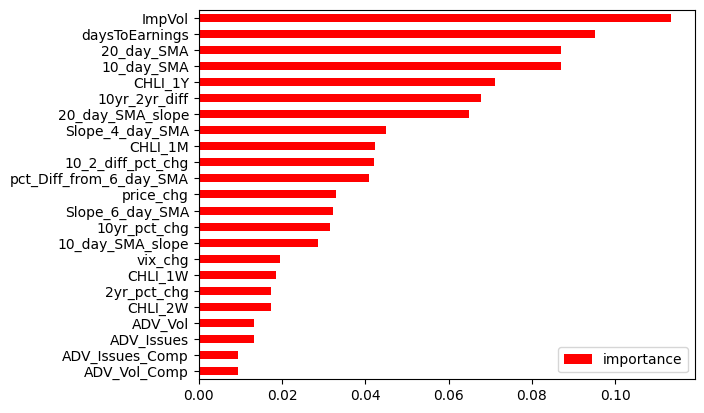

In [31]:

stockutils.plot_feature_importances(X_train=X_train, estimator=rf_gs.best_estimator_)

# PCA 
Out of curiosity, what does affect does running PCA on the data prior to training end up with?

In [32]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler

# yay! this is nice!  now our transform creates a pandas dataframe instead of numpy array
set_config(transform_output="pandas")

pca_scaler = StandardScaler()
pca = PCA(n_components=5)

pipeline = make_pipeline(pca_scaler, pca)

pipeline.fit(X_train)
pca.get_feature_names_out(input_features=X_train.columns)

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4'], dtype=object)

In [33]:
transformed = pca.transform(X_train)
print(transformed.shape)

(1896, 5)


In [34]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA_ feature')
plt.show()

In [35]:
#rf_gs.fit(transformed, y_train)

#y_pred = rf_gs.predict(pca.transform(X_test))

In [36]:
#print("Accuracy: ", accuracy_score(y_test, y_pred))

30%, hmm... that's pretty bad

# XGBoost

In [37]:

#y_train_xgb = pd.Categorical(y_train['Target']).codes
y_train_xgb = pd.Categorical(y_train).codes

#y_test_xgb = pd.Categorical(y_test['Target']).codes
y_test_xgb = pd.Categorical(y_test).codes

In [38]:
import xgboost as xgb

#log to weights and biases
run_name = f"XGBoostClassifier_5_10_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

tscv = 10

evals = [(X_train, y_train_xgb), (X_test, y_test_xgb)]



cls = xgb.XGBClassifier(objective='multi:softmax', 
                        num_class=3,
                        n_estimators=500, 
                        seed=42, 
                        importance_type='gain', 
                        device="cuda",
                        early_stopping_rounds=20,
                        eval_metric=['merror', 'mlogloss'],
                        callbacks=[WandbCallback(log_feature_importance=True, importance_type="gain")]
                        ) 
#Base classifier 
cls.fit(X_train, y_train_xgb, eval_set=evals)
y_pred_train_xgb = cls.predict(X_train)
y_pred_test_xgb = cls.predict(X_test)

print("Base classifier training set accuracy:", accuracy_score(y_train_xgb, y_pred_train_xgb))
print("Base classifier test set accuracy:", accuracy_score(y_test_xgb, y_pred_test_xgb))
print("Base classifier params:", cls.get_params())

# alpha is L1 regularization - zeros some weights
#lambda is L2 regularization - smoother penalty
# cls_params = {
#     'learning_rate':[0.001,0.01, 0.1, 0.2, 1, 10],
#     'max_depth':[1,2],
#     'subsample':[ 0.2, 0.5, 0.7, 0.8, 0.9]
# }

cls_params = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate':[0.001, 0.01, 0.1],
    'max_depth':[2, 4, 6],
    'subsample':[ 0.1, 0.2]
}
xgb_gs = RandomizedSearchCV(cls, param_distributions=cls_params, cv=tscv, scoring='accuracy', verbose=False)

#xgb_gs = GridSearchCV(cls, param_grid=cls_params, cv=tscv, scoring='accuracy', verbose=False)

xgb_gs.fit(X_train, y_train_xgb, eval_set=evals)

y_pred = xgb_gs.predict(X_test)

run.summary['accuracy'] = accuracy_score(y_test_xgb, y_pred)


# calculate ROI, need a dataframe with predicted 'Target' and actual 'close'
xgb_preds = pd.DataFrame(data=y_pred, columns=["Target"], index=y_test.index.copy())
xgb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(xgb_preds, init_value=1000, init_price=xgb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

print("Test Accuracy: ", accuracy_score(y_test_xgb, y_pred))
print("Best Params", xgb_gs.best_params_)

wandb.sklearn.plot_confusion_matrix(y_test_xgb, y_pred)

run.finish()

[0]	validation_0-merror:0.19726	validation_0-mlogloss:0.89451	validation_1-merror:0.51158	validation_1-mlogloss:1.06002
[1]	validation_0-merror:0.15665	validation_0-mlogloss:0.75405	validation_1-merror:0.55789	validation_1-mlogloss:1.04300
[2]	validation_0-merror:0.13555	validation_0-mlogloss:0.65877	validation_1-merror:0.62105	validation_1-mlogloss:1.06259
[3]	validation_0-merror:0.12869	validation_0-mlogloss:0.59091	validation_1-merror:0.41474	validation_1-mlogloss:1.00984
[4]	validation_0-merror:0.10970	validation_0-mlogloss:0.53155	validation_1-merror:0.58105	validation_1-mlogloss:1.04323
[5]	validation_0-merror:0.10338	validation_0-mlogloss:0.48505	validation_1-merror:0.53053	validation_1-mlogloss:1.03465
[6]	validation_0-merror:0.09599	validation_0-mlogloss:0.44659	validation_1-merror:0.54526	validation_1-mlogloss:1.02900
[7]	validation_0-merror:0.09177	validation_0-mlogloss:0.41904	validation_1-merror:0.61684	validation_1-mlogloss:1.06865
[8]	validation_0-merror:0.08544	validati

/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:42:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1706051839871/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-merror:0.31118	validation_0-mlogloss:1.09607	validation_1-merror:0.38105	validation_1-mlogloss:1.09725
[5]	validation_0-merror:0.31487	validation_0-mlogloss:1.09556	validation_1-merror:0.37684	validation_1-mlogloss:1.09699
[6]	validation_0-merror:0.31065	validation_0-mlogloss:1.09507	validation_1-merror:0.36842	validation_1-mlogloss:1.09683
[7]	validation_0-merror:0.30696	validation_0-mlogloss:1.09457	validation_1-merror:0.38526	validation_1-mlogloss:1.09681
[8]	validation_0-merror:0.30802	validation_0-mlogloss:1.09410	validation_1-merror:0.36632	validation_1-mlogloss:1.09646
[9]	validation_0-merror:0.30432	validation_0-mlogloss:1.09366	validation_1-merror:0.40421	validation_1-mlogloss:1.09661
[10]	validation_0-merror:0.30643	validation_0-mlogloss:1.09319	validation_1-merror:0.43368	validation_1-mlogloss:1.09656
[11]	validation_0-merror:0.30116	validation_0-mlogloss:1.09269	validation_1-merror:0.42737	validation_1-mlogloss:1.09640
[12]	validation_0-merror:0.29747	valid

In [39]:
results = xgb_gs.best_estimator_.evals_result()


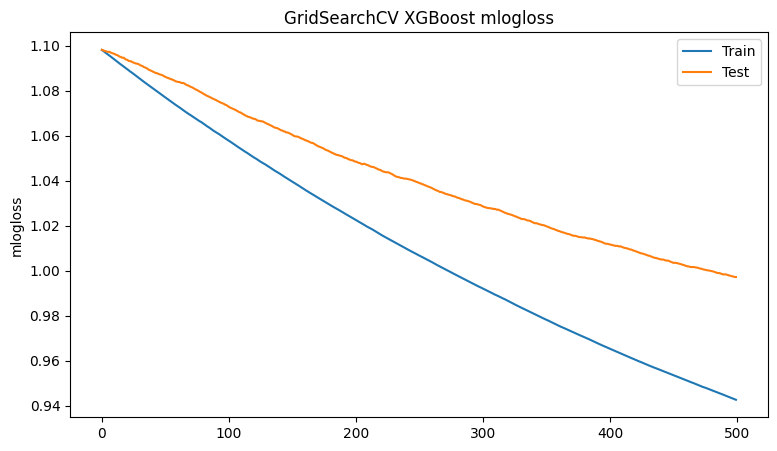

In [40]:
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [41]:
run.finish()

# XGBoost #2 using native API ( DMatrix, etc)

In [42]:
# we will change our main dataset slightly
#stockdf, targetdf, otherdf
from sklearn.preprocessing import OrdinalEncoder


In [43]:
y_train_xgb = pd.Categorical(y_train).codes
y_test_xgb = pd.Categorical(y_test).codes

y_encoded = OrdinalEncoder().fit_transform(targetdf)


#X_train, X_test, y_train, y_test = train_test_split(stockdf,y_encoded, train_size=0.8,shuffle=False)


train_xgb = xgb.DMatrix(X_train, y_train_xgb, enable_categorical=True)

test_xgb = xgb.DMatrix(X_test, y_test_xgb, enable_categorical=True)

In [44]:
import xgboost as xgb
from wandb.integration.xgboost import WandbCallback

run_name = f"XGBoostClassNative_5_10_{int(time.time())}"
run = wandb.init(entity="christopherandrews", 
                project="StockPredictor", 
                name=run_name, save_code=False, 
                settings=wandb.Settings(start_method="fork"), 
                reinit=True, 
                sync_tensorboard=True,)

params = {"objective": "multi:softmax"
        , "device":"cuda"
        ,"num_class":3
        , 'max_depth': 2
        , 'learning_rate': 0.001
        , 'random_state': 42
        , 'eval_metric': ['auc']}

# alpha is L1 regularization - zeros some weights
#lambda is L2 regularization - smoother penalty
# params = {
#         "objective": "multi:softprob"
#         , "num_class":3
#         , 'gamma': 1               ## def: 0
#         , 'learning_rate': 0.1     ## def: 0.1
#         , 'max_depth': 3
#         , 'min_child_weight': 100  ## def: 1
#         , 'nthread': 24
#         , 'random_state': 42
#         , 'reg_alpha': 0
#         , 'reg_lambda': 0          ## def: 1
#         , 'eval_metric': ['auc', 'logloss']
#         , "device":"cuda" # use to train on GPU
#     }

evals = [(train_xgb, "train"), (test_xgb, "test")]
num_rounds = 100000

cls2 = xgb.train(params=params, 
                dtrain=train_xgb, 
                num_boost_round=num_rounds, 
                evals=evals, 
                verbose_eval=10, 
                early_stopping_rounds=200, 
                callbacks=[WandbCallback(log_feature_importance=True, importance_type="gain")])

y_pred_test_xgb = cls2.predict(test_xgb, iteration_range=(0, cls2.best_iteration + 1))

run.summary['accuracy'] = accuracy_score(y_test_xgb, y_pred_test_xgb)
print("Test Accuracy: ", accuracy_score(y_test_xgb, y_pred_test_xgb))
xgb_preds = pd.DataFrame(data=y_pred_test_xgb, columns=["Target"], index=y_test.index.copy())
xgb_preds['close'] = other_test['close']
run.summary["ROI"] = stockutils.calculate_total_gains_bhs(xgb_preds, init_value=1000, init_price=xgb_preds['close'][0])
run.summary["Buy And Hold (Base ROI)"] = bah_ROI
run.summary["Max ROI"] = max_ROI

wandb.sklearn.plot_confusion_matrix(y_test_xgb, y_pred_test_xgb)

run.finish()


[0]	train-auc:0.71984	test-auc:0.65548
[10]	train-auc:0.71980	test-auc:0.65096
[20]	train-auc:0.71980	test-auc:0.65094
[30]	train-auc:0.71980	test-auc:0.65094
[40]	train-auc:0.71980	test-auc:0.65094
[50]	train-auc:0.71975	test-auc:0.65094
[60]	train-auc:0.72130	test-auc:0.65094
[70]	train-auc:0.72132	test-auc:0.65034
[80]	train-auc:0.72847	test-auc:0.65028
[90]	train-auc:0.72847	test-auc:0.64941
[100]	train-auc:0.73113	test-auc:0.64941
[110]	train-auc:0.73070	test-auc:0.64941
[120]	train-auc:0.73424	test-auc:0.64965
[130]	train-auc:0.73487	test-auc:0.64909
[140]	train-auc:0.73683	test-auc:0.64909
[150]	train-auc:0.73710	test-auc:0.64996
[160]	train-auc:0.73777	test-auc:0.64996
[170]	train-auc:0.73835	test-auc:0.64996
[180]	train-auc:0.73920	test-auc:0.65010
[190]	train-auc:0.73901	test-auc:0.65010
[200]	train-auc:0.73907	test-auc:0.65070
Test Accuracy:  0.6336842105263157
Buying 5 shares for 191.94. Remaining Balance: 40.299999999999955
Selling all shares for 193.22, cash balance: $100

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test_xgb, y_pred_test_xgb), annot=True, fmt="d")

<Axes: >

### show the tree 

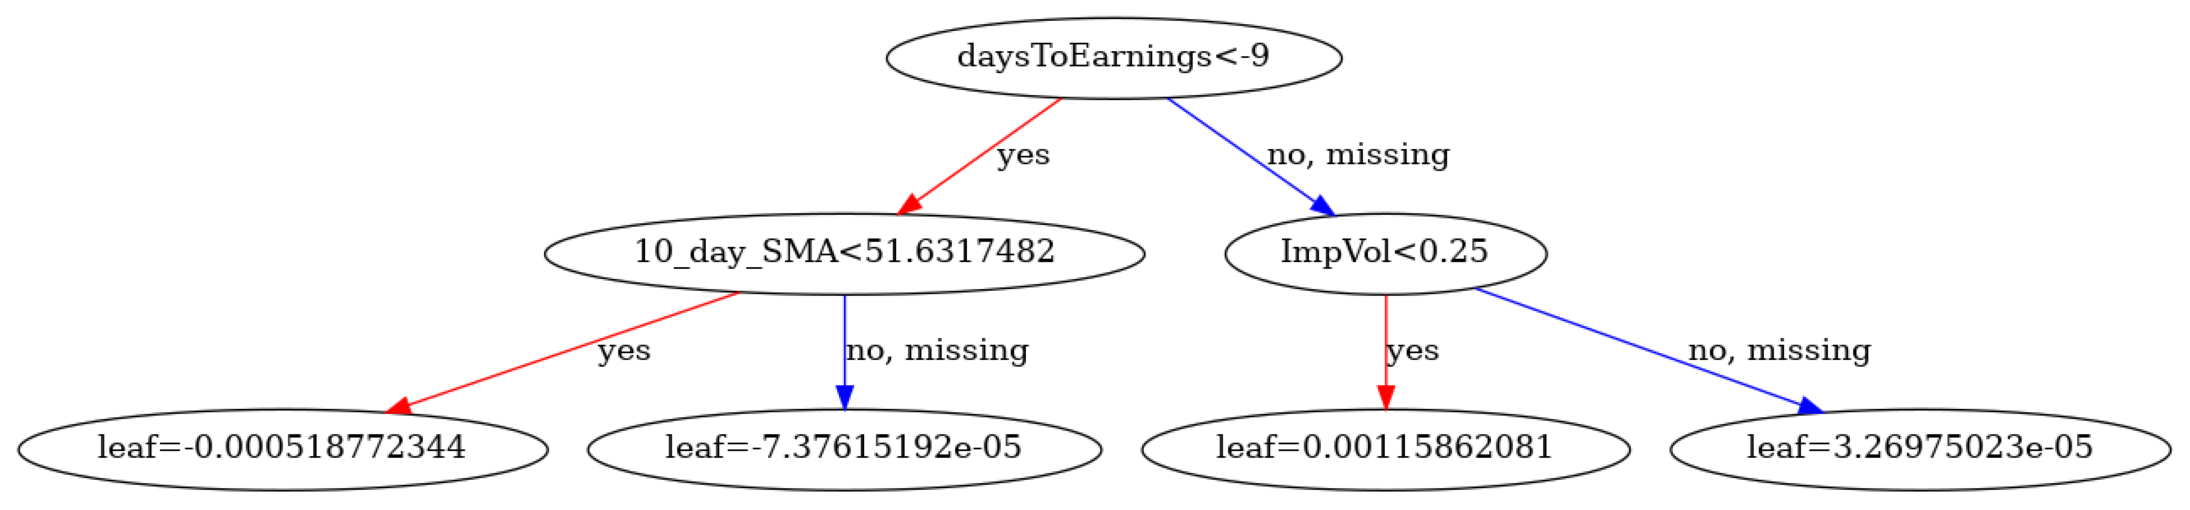

In [46]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28,12
xgb.plot_tree(cls2)
plt.show()

In [47]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(cls2, ax=ax, importance_type="gain")
plt.show()

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test_xgb, y_pred), annot=True, fmt="d")


<Axes: >

In [49]:
stockutils.plot_feature_importances(X_train=X_train, estimator=xgb_gs.best_estimator_)

XGBoost also has an equivalent feature importance graph

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

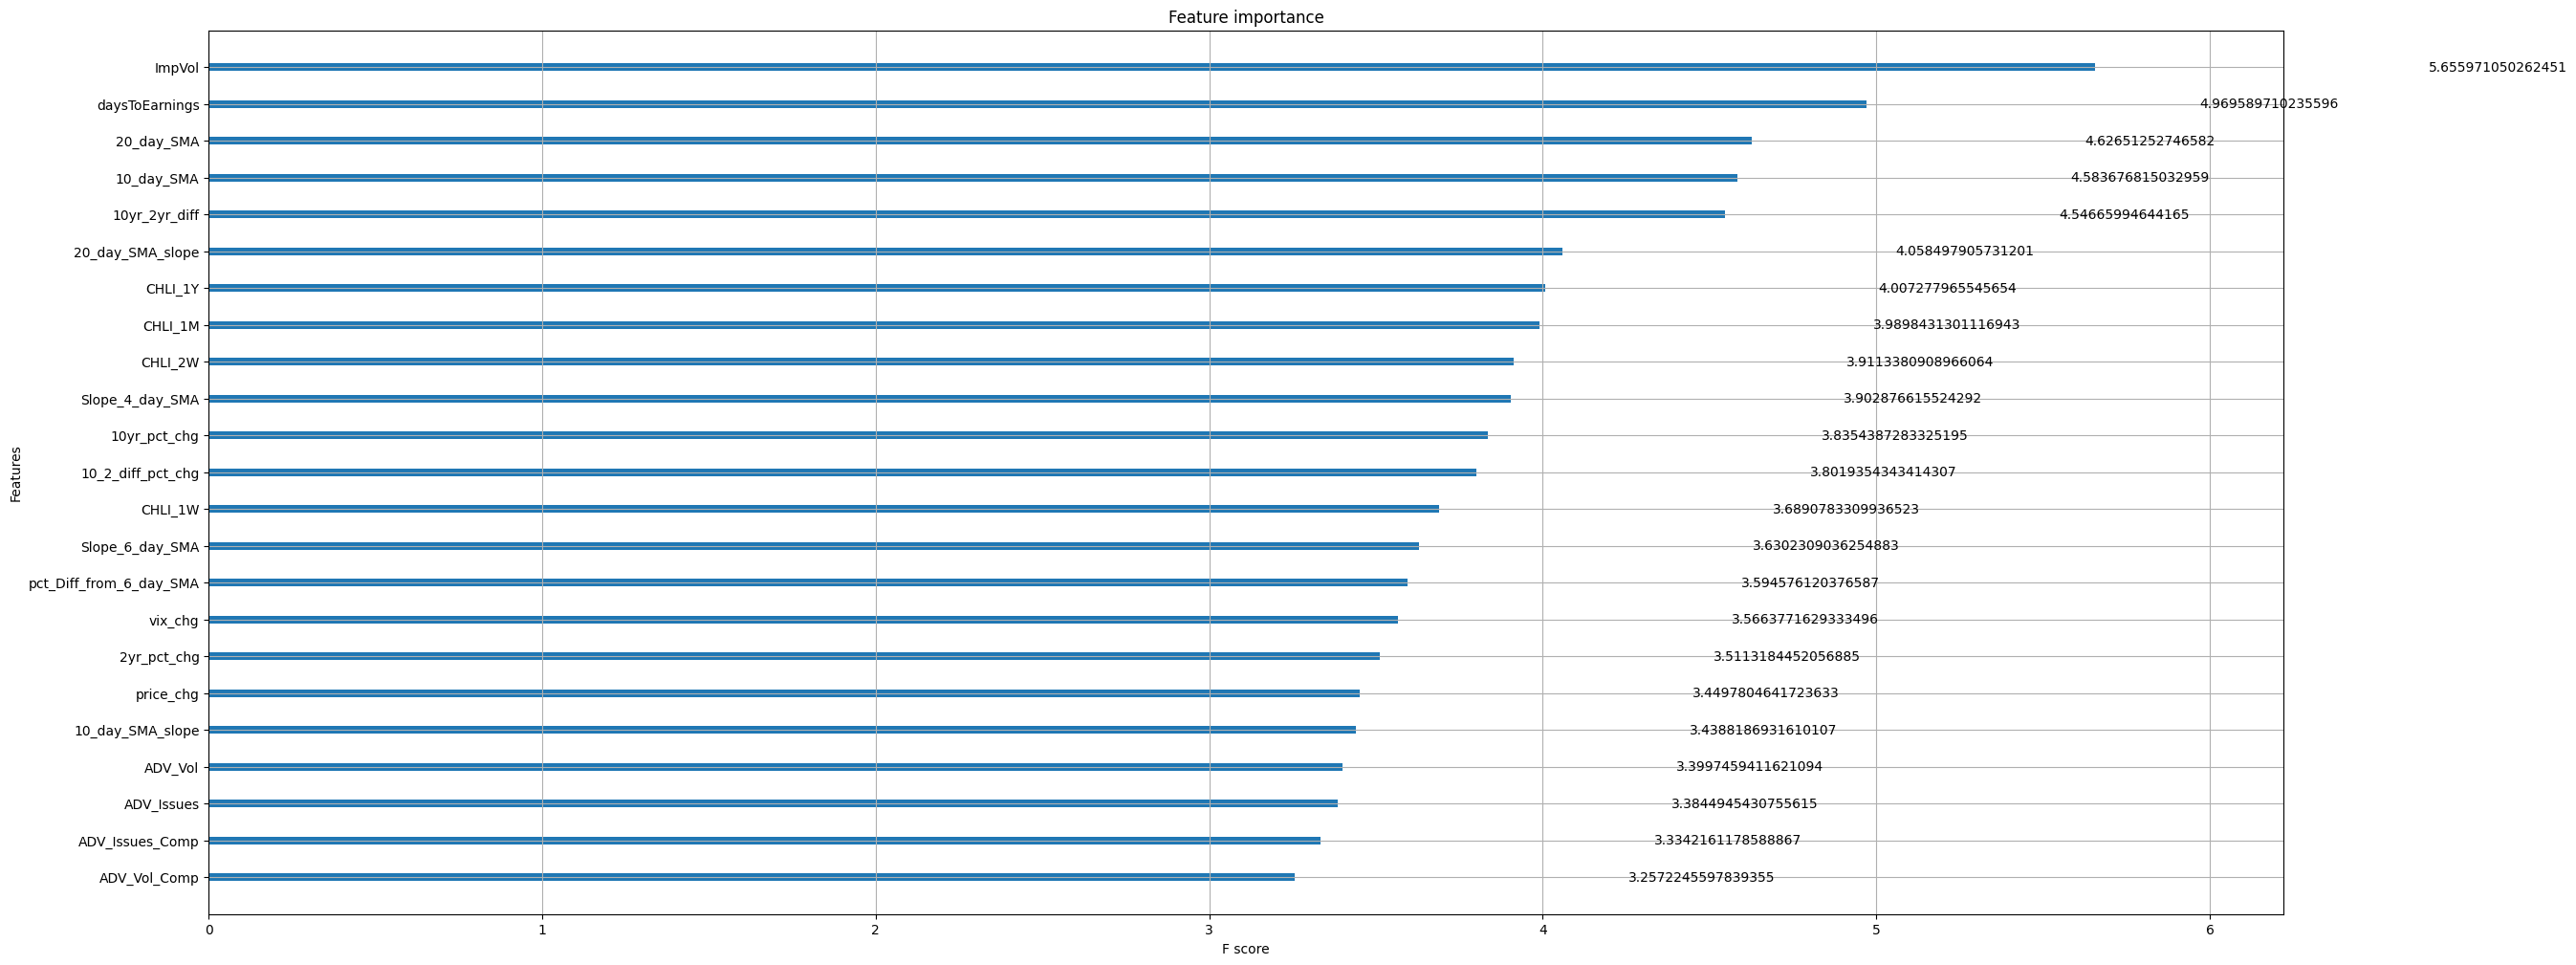

In [50]:
xgb.plot_importance(xgb_gs.best_estimator_, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

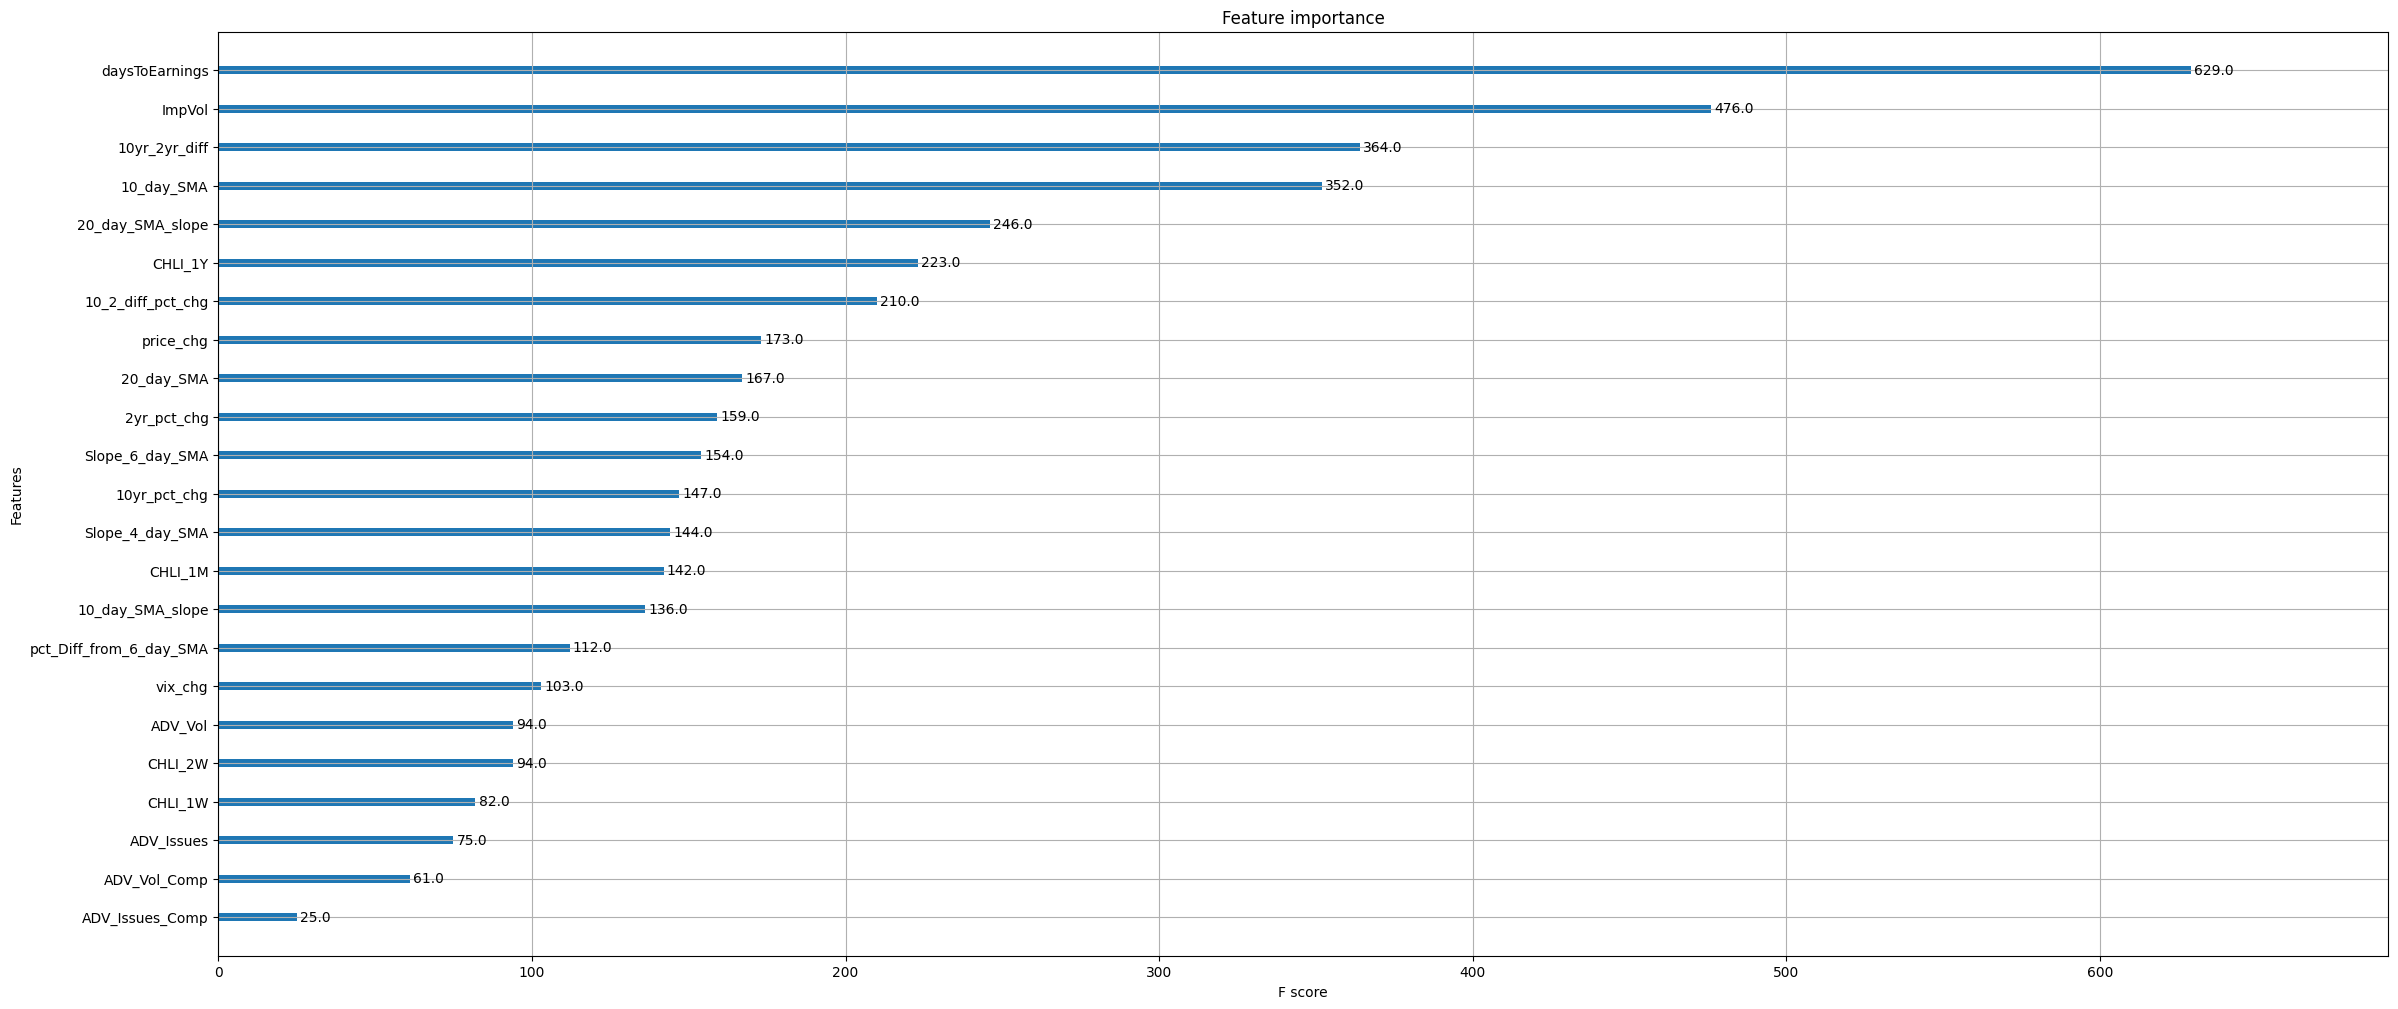

In [51]:
xgb.plot_importance(xgb_gs.best_estimator_)

# How do these models perform on the stock market?  

This won't be quite accurate, (we should use a different stock, or timeframe perhaps) but lets run the model predictions on the full dataset, plot the buys and sells, and then calculate our return

In [52]:
#plop the target value into the otherdf for plotting
otherdf['Target'] = targetdf['Target']

otherdf

close    vix  2yr_Yield  10yr_Yield Target
date                                                    
1/13/2015   27.5550  20.56      0.541       1.905   HOLD
1/14/2015   27.4500  21.48      0.501       1.855    BUY
1/15/2015   26.7050  22.39      0.420       1.728    BUY
1/16/2015   26.4975  20.95      0.488       1.831    BUY
1/20/2015   27.1800  19.89      0.499       1.791    BUY
...             ...    ...        ...         ...    ...
6/7/2024   196.8900  12.22      4.889       4.433    BUY
6/10/2024  193.1200  12.74      4.885       4.471    BUY
6/11/2024  207.1500  12.85      4.834       4.402   HOLD
6/12/2024  213.0700  12.04      4.756       4.318   HOLD
6/13/2024  214.2400  11.94      4.703       4.248   HOLD

[2371 rows x 5 columns]

In [53]:
# gather full predictions on the whole dataset
dtc_y_full_pred = dtc_gs.predict(stockdf)
adb_y_full_pred = adb_gs.predict(stockdf)
gbc_y_full_pred = gbc_gs.predict(stockdf)
rf_y_full_pred = rf_gs.predict(stockdf)

xgb_y_full_pred = xgb_gs.predict(stockdf)

#next, our calculate_total_gains requires a dataframe with date index, and 'close' and 'Target' features.


y_full_xgb = pd.Categorical(y_orig).codes
full_xgb = xgb.DMatrix(stockdf, y_full_xgb, enable_categorical=True)
xgb_native_y_full_pred = cls2.predict(full_xgb)


In [54]:
#dtc_y_full_pred

In [55]:
#dtc_y_full_pred = dtc_gs.predict(stockdf)

In [56]:
dtc_predictions = targetdf.copy()
dtc_predictions['Target'] = dtc_y_full_pred
dtc_predictions['close'] = otherdf['close']

adb_predictions = targetdf.copy()
adb_predictions['Target'] = adb_y_full_pred
adb_predictions['close'] = otherdf['close']

gbc_predictions = targetdf.copy()
gbc_predictions['Target'] = gbc_y_full_pred
gbc_predictions['close'] = otherdf['close']

rf_predictions = targetdf.copy()
rf_predictions['Target'] = rf_y_full_pred
rf_predictions['close'] = otherdf['close']

xgb_predictions = targetdf.copy()
xgb_predictions['Target'] = xgb_y_full_pred
xgb_predictions['close'] = otherdf['close']

xgb_native_predictions = targetdf.copy()
xgb_native_predictions['Target'] = xgb_native_y_full_pred
xgb_native_predictions['close'] = otherdf['close']





In [57]:
import math

def calculate_total_gains(df, init_value, init_price, transaction_cost_fixed=0.0  ):
    price = init_price
    num_shares_owned = 0
    gain = 0.0
    cash_balance = init_value
    for idx, row in df.iterrows():
        price = df.loc[idx,'close']#price + (price * row['price_change_pct'])
        if row["Target"] == 'BUY' or row['Target'] == 0:
            max_shares = math.floor(cash_balance/price)
            if max_shares > 0:
                num_shares_owned += max_shares
                cash_balance = cash_balance - (max_shares*price)
                print("Buying {} shares for {:0.2f}. Remaining Balance: {}".format(max_shares, price, cash_balance))
        elif row["Target"] == 'SELL' or row['Target']== 2:
            cash_balance = cash_balance + (num_shares_owned * price)
            if num_shares_owned != 0:
                print("Selling all shares for {:0.2f}, cash balance: ${}".format(price, cash_balance))
            num_shares_owned = 0
    #sell at the end for gain calculation if we are holding stock
    cash_balance = cash_balance + (num_shares_owned * price)   
    print("Selling all remaining held shares, cash balance: ${} ***********************".format(cash_balance))
    roi = cash_balance - init_value
    return roi

In [58]:
initial_investment = 1000

### Buy and Hold

In [59]:
# Buy and hold performance
starting_price = otherdf['close'][0]
ending_price = otherdf['close'][-1]
print("Starting price:", starting_price)
print("Ending price:", ending_price)
num_shares = math.floor(initial_investment/starting_price)
gain = num_shares*ending_price
gain

Starting price: 27.555
Ending price: 214.24


7712.64

### Ideal

In [60]:
# ideal performance


calculate_total_gains(otherdf, init_value=initial_investment, init_price=otherdf['close'][0])

Buying 36 shares for 27.45. Remaining Balance: 11.800000000000068
Selling all shares for 33.04, cash balance: $1201.33
Buying 46 shares for 25.78. Remaining Balance: 15.449999999999818
Selling all shares for 29.07, cash balance: $1352.6699999999998
Buying 49 shares for 27.38. Remaining Balance: 11.294999999999845
Selling all shares for 29.88, cash balance: $1475.1699999999998
Buying 52 shares for 28.09. Remaining Balance: 14.749999999999773
Selling all shares for 29.34, cash balance: $1540.1699999999998
Buying 63 shares for 24.11. Remaining Balance: 21.082499999999754
Selling all shares for 24.99, cash balance: $1595.4524999999996
Buying 66 shares for 24.07. Remaining Balance: 7.162499999999454
Selling all shares for 27.61, cash balance: $1829.4224999999994
Buying 79 shares for 23.13. Remaining Balance: 2.3499999999994543
Selling all shares for 24.71, cash balance: $1954.2424999999994
Buying 84 shares for 23.01. Remaining Balance: 21.402499999999236
Selling all shares for 29.37, cash b

616803.365

### Decision Tree Performance

In [61]:

#Decision Tree Classifier
calculate_total_gains(dtc_predictions, init_value=initial_investment, init_price=dtc_predictions['close'][0])

Selling all remaining held shares, cash balance: $1000.0 ***********************


0.0

Pretty poor ROI compared to perfect, and is worse than buy and hold

In [62]:

#test_full['price'] = X_test_orig['close'].to_numpy()
#pred_full['price'] = X_test_orig['close'].to_numpy()
#test_full.head()

a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=dtc_predictions, x=dtc_predictions.index, y='close', hue='Target',s=20)

#sns.scatterplot(data=otherdf, x=otherdf.index, y='close', hue='Target', size=0.1 )

<Axes: xlabel='date', ylabel='close'>

### AdaBoost Performance

In [63]:
#AdaBoost Model
calculate_total_gains(adb_predictions, init_value=initial_investment, init_price=adb_predictions['close'][0])

Buying 31 shares for 32.13. Remaining Balance: 4.047500000000127
Selling all remaining held shares, cash balance: $6645.487500000001 ***********************


5645.487500000001

<Axes: xlabel='date', ylabel='close'>

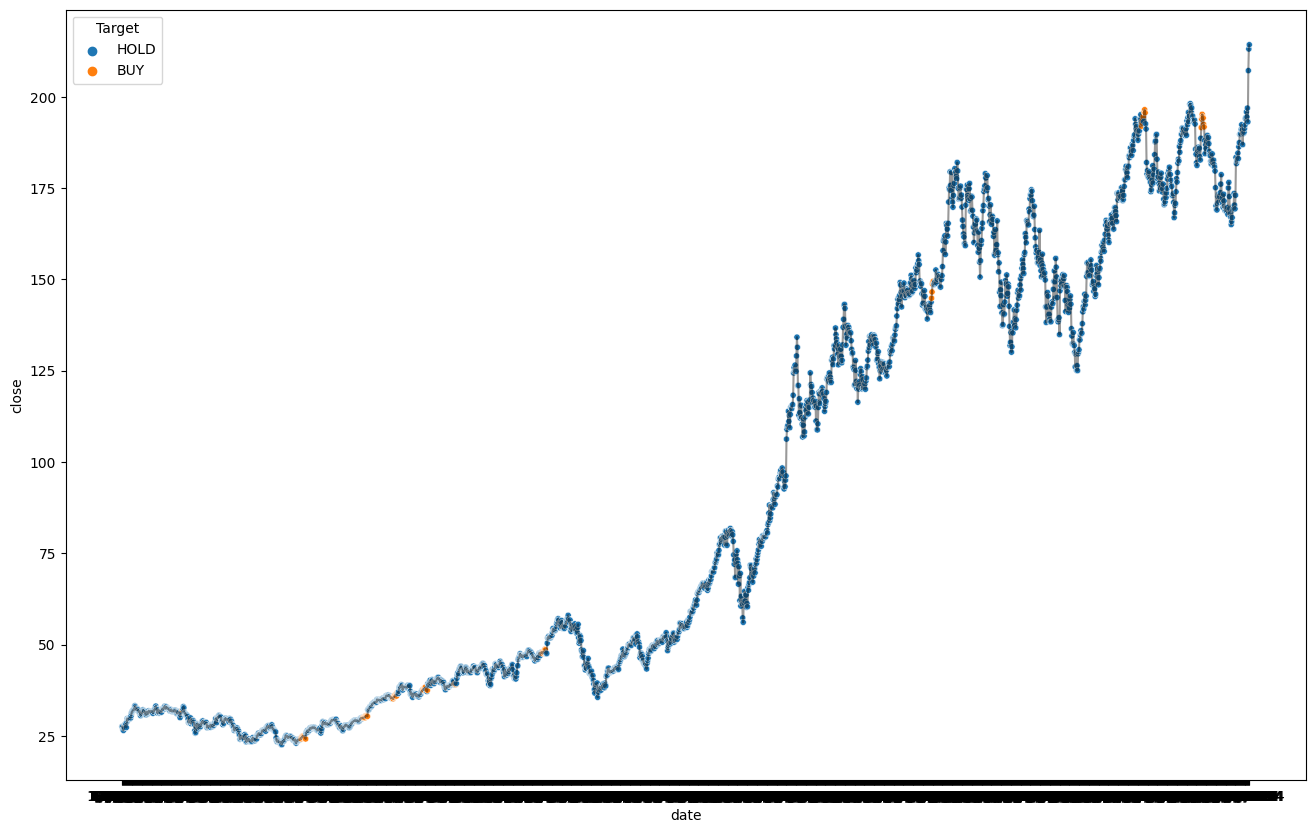

In [64]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=adb_predictions, x=adb_predictions.index, y='close', hue='Target',s=20)

### Gradient Boost Performance

In [65]:
#Gradient Boost
calculate_total_gains(gbc_predictions, init_value=initial_investment, init_price=gbc_predictions['close'][0])

Buying 6 shares for 151.00. Remaining Balance: 94.0
Selling all shares for 195.10, cash balance: $1264.6
Buying 6 shares for 193.89. Remaining Balance: 101.25999999999999
Selling all shares for 188.04, cash balance: $1229.5
Selling all remaining held shares, cash balance: $1229.5 ***********************


229.5

<Axes: xlabel='date', ylabel='close'>

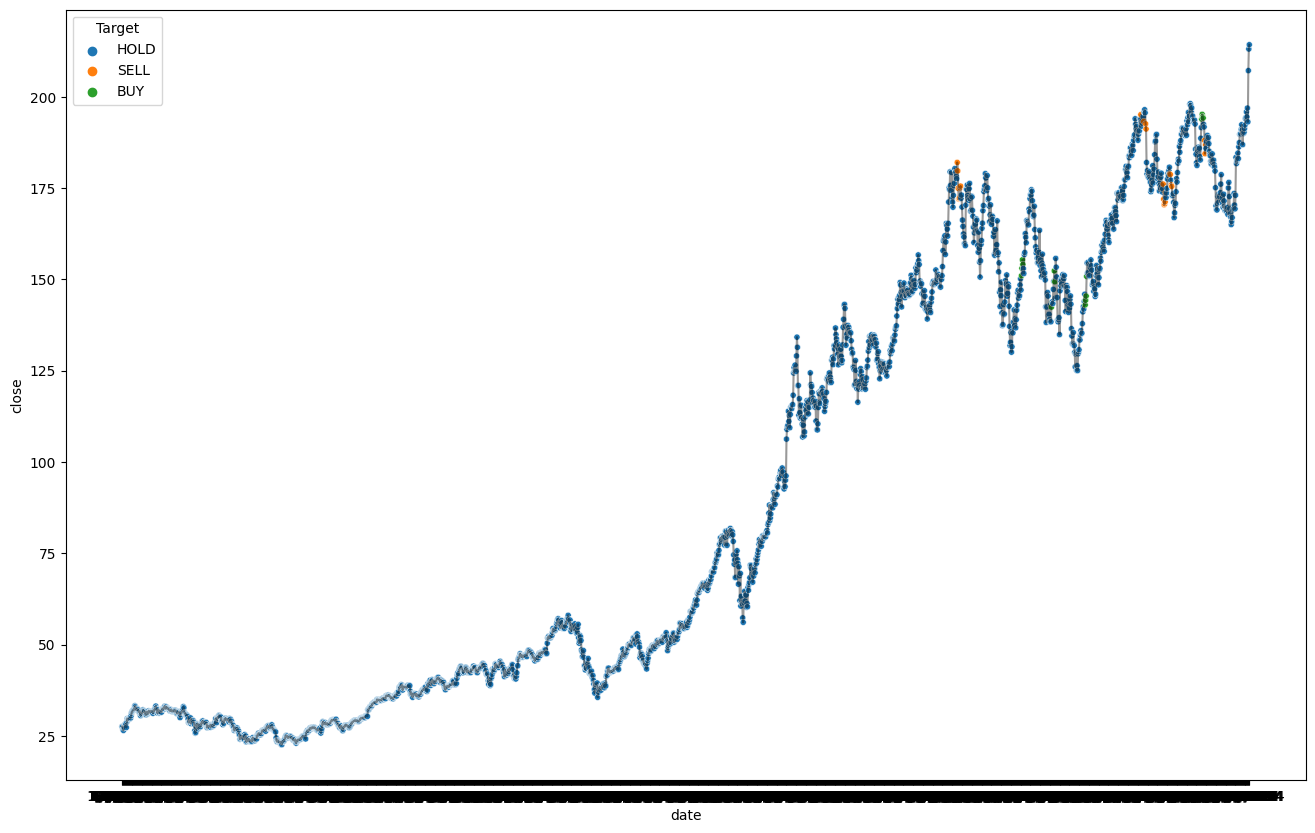

In [66]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=gbc_predictions, x=gbc_predictions.index, y='close', hue='Target',s=20)

### Random Forest Performance

In [67]:
calculate_total_gains(rf_predictions, init_value=initial_investment, init_price=rf_predictions['close'][0])

Selling all remaining held shares, cash balance: $1000.0 ***********************


0.0

<Axes: xlabel='date', ylabel='close'>

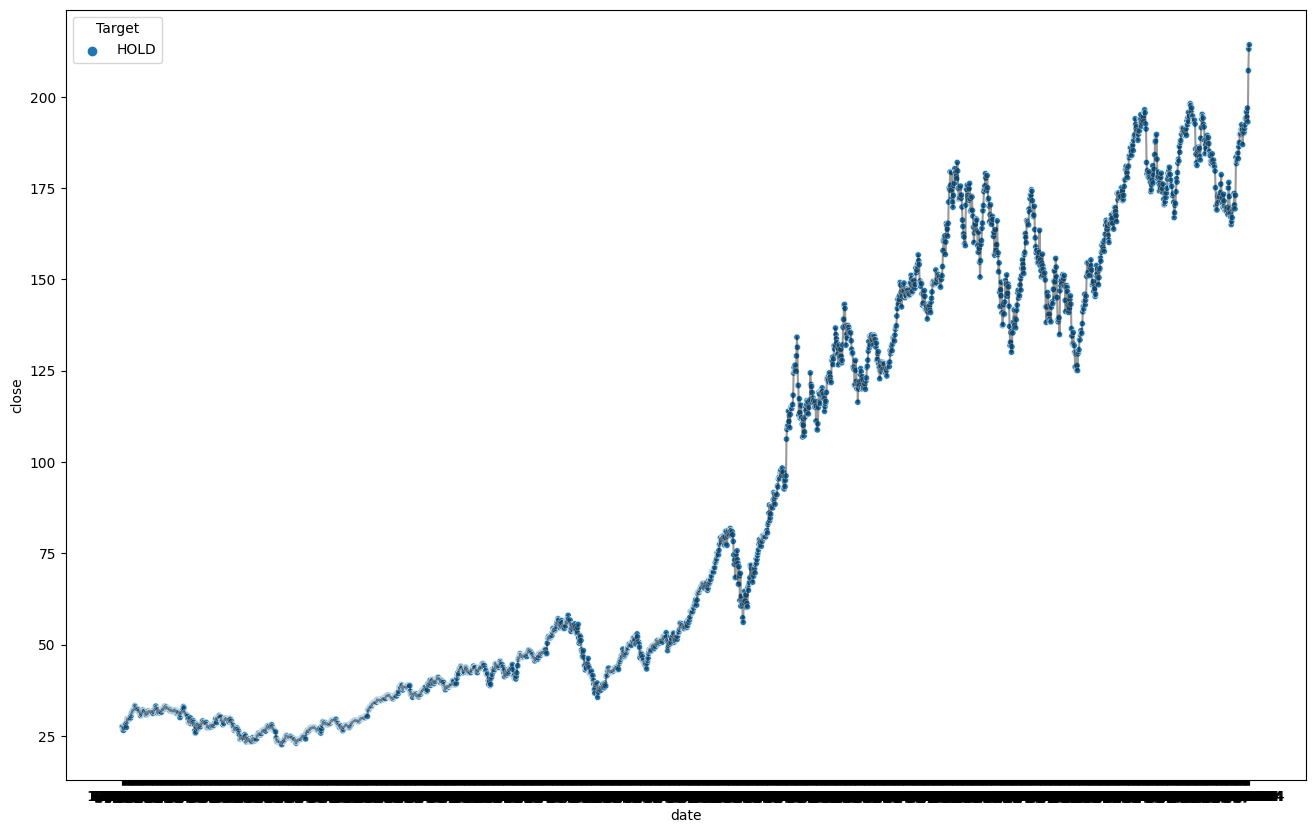

In [68]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=rf_predictions, x=rf_predictions.index, y='close', hue='Target',s=20)

### XGBoost Performance

In [69]:
calculate_total_gains(xgb_predictions, init_value=initial_investment, init_price=xgb_predictions['close'][0])

Buying 12 shares for 77.24. Remaining Balance: 73.15000000000009
Buying 1 shares for 68.38. Remaining Balance: 4.7700000000000955
Selling all remaining held shares, cash balance: $2789.89 ***********************


1789.8899999999999

<Axes: xlabel='date', ylabel='close'>

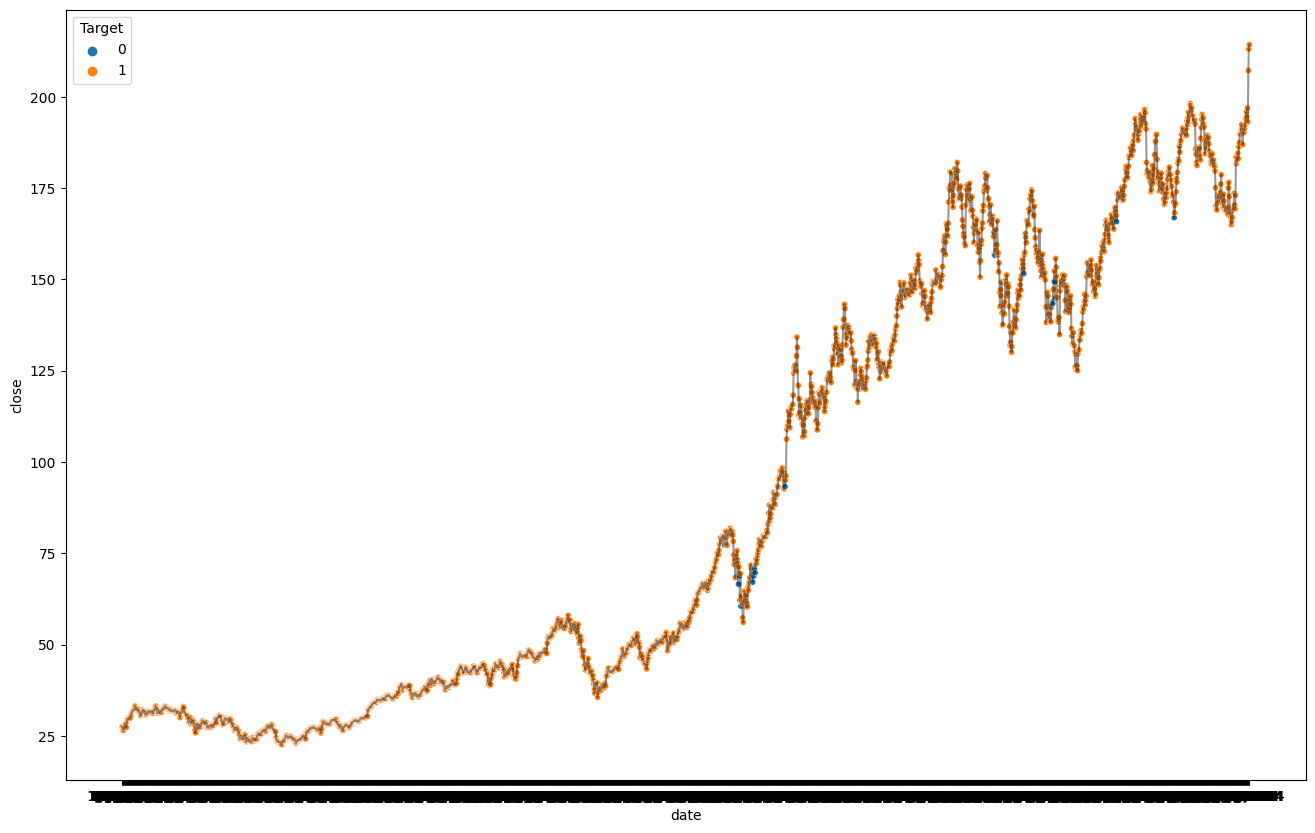

In [70]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=xgb_predictions, x=xgb_predictions.index, y='close', hue='Target',s=20)

<Axes: xlabel='date', ylabel='close'>

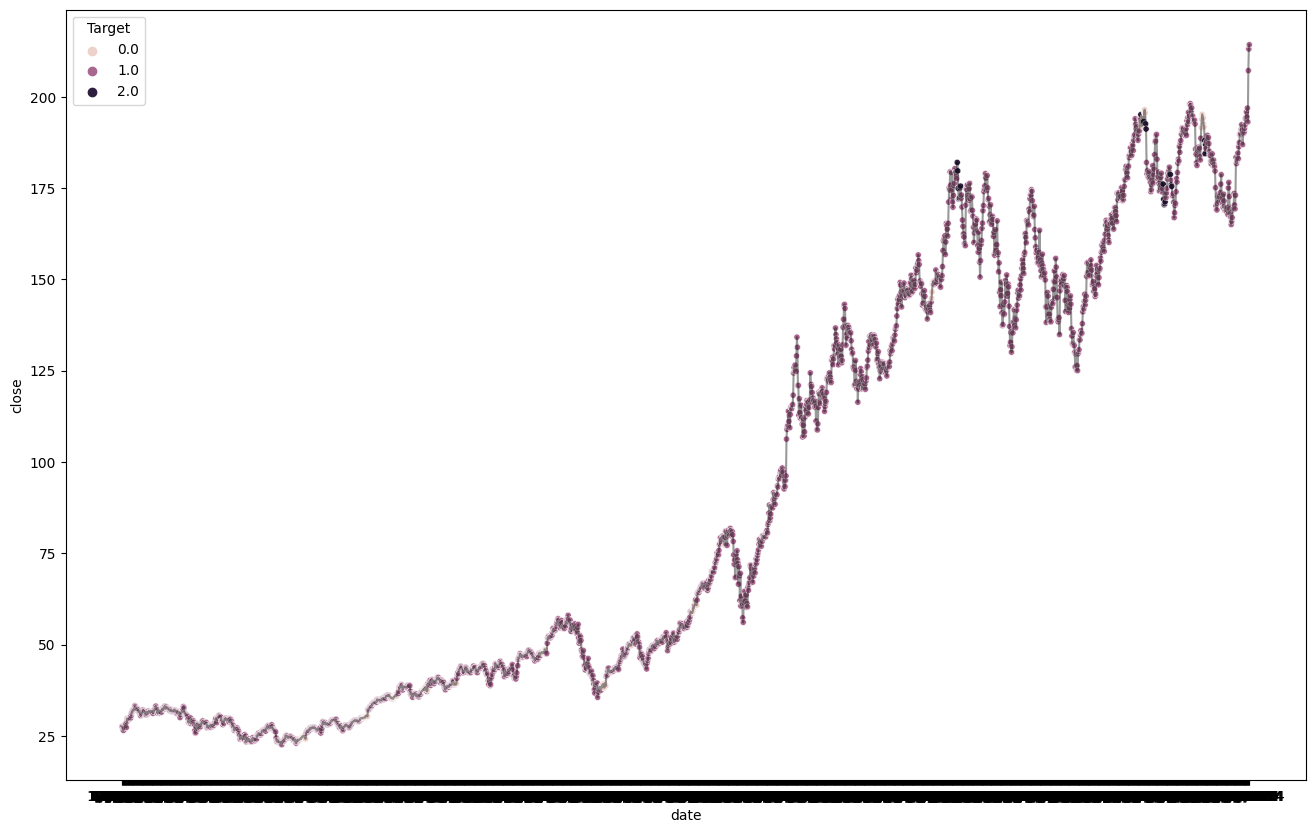

In [71]:
a4_dims = (16,10)
fig, ax = plt.subplots(figsize=a4_dims)
#plot the actual close line
ax=sns.lineplot(data=otherdf, x=otherdf.index, y='close', c='black', alpha=0.4)
# plot the predicted values
sns.scatterplot(data=xgb_native_predictions, x=xgb_native_predictions.index, y='close', hue='Target',s=20)